![tox21](https://www.researchgate.net/profile/Sepp-Hochreiter/publication/320828461/figure/fig1/AS:562467181993985@1511114034491/Overview-of-the-Tox21-challenge-dataset.png)

# Benchmarks for TOX21

## Background
Tox21 is a well-known dataset for researchers in machine learning for drug discovery. The data set provided by the Tox21 Data Challenge included approximately 12 000 compounds. It consists of a multi-label classification task with 12 labels, with most labels missing and a strong imbalance towards the negative class. Each subchallenge required the prediction of a different type of toxicity. The sub-challenges were split between two panels: Seven of the twelve sub-challenges dealt with Nuclear Receptor (NR) signaling pathways, the remaining five with the Stress Response (SR) pathways. Nuclear receptors are important components in cell communication and control, and are involved in development,
metabolism and proliferation. Toxicity can also cause cellular stress which in term can
lead to apoptosis. Therefore the Tox21 data also includes five tasks on various stress response indicators. We chose Tox21 in our ToyMix since it is very similar to the larger proposed bioassay dataset, PCBA_1328_1564k both in terms of sparsity and imbalance and to the L1000 datasets in terms of imbalance.

## Assay information
In qHTS (quantitative high throughput screens), many thousands of compounds are screened in a single experiment across a broad concentration range in order to generate concentration–response curves. The method identifies compounds with a wide range of activities with a much lower false-positive or false-negative rate. The resulting concentration–response curves can be classified to rapidly identify actives and inactives with a variety of potencies and efficacies, producing rich data sets that can be mined for reliable biological activities.

## Benchmarking
**The goal** of this benchmark is to have the best predictive model for classifying molecules as having activity against toxicity-related proteins: nuclear receptors and stress response indicators.

## Description of readout:
- Readouts: MSE
- Optimization objective: Lower value

## Data resource
Reference: [Improving the human hazard characterization of chemicals: a Tox21 update.](https://europepmc.org/article/MED/23603828)






In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import datamol as dm

# polaris benchmark
from polaris.benchmark import MultiTaskBenchmarkSpecification

# polaris hub
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[2]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

In [3]:
# Get the owner and organization
org = "Graphium"
data_name = "tox21"
dataset_name = "tox21-v1"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"

owner = HubOwner(slug=org.lower(), type="organization")
owner

HubOwner(slug='graphium', external_id=None, type='organization')

In [4]:
BENCHMARK_DIR = f"{gcp_root}/benchmarks"
DATASET_JSON = f"{gcp_root}/datasets/{dataset_name}/dataset.json"

FIGURE_DIR = f"{gcp_root}/figures"

### Load existing data

In [5]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

<a id="benchmark"></a>
## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-test set and defining evaluation metrics which is used to establish baseline performance level. 

In [6]:
data_cols = [
    "NR-AR",
    "NR-AR-LBD",
    "NR-AhR",
    "NR-Aromatase",
    "NR-ER",
    "NR-ER-LBD",
    "NR-PPAR-gamma",
    "SR-ARE",
    "SR-ATAD5",
    "SR-HSE",
    "SR-MMP",
    "SR-p53",
]

mol_col = "smiles"

### Get the train/test splits

In [7]:
import torch

split_path = "gs://polaris-public/polaris-recipes/org-Graphium/tox21/data/raw/Tox21_random_splits.pt"
with dm.fs.fsspec.open(split_path) as f:
    split_dict = torch.load(f)

splits = tuple(split_dict.values())

### Check distribution of train/test set in the chemical space

  0%|          | 0/7831 [00:00<?, ?it/s]

[00:32:40] WARNING: not removing hydrogen atom without neighbors
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'https://storage.googleapis.com/polaris-public/polaris-recipes/org-Graphium/tox21/figures/chemspace.png'

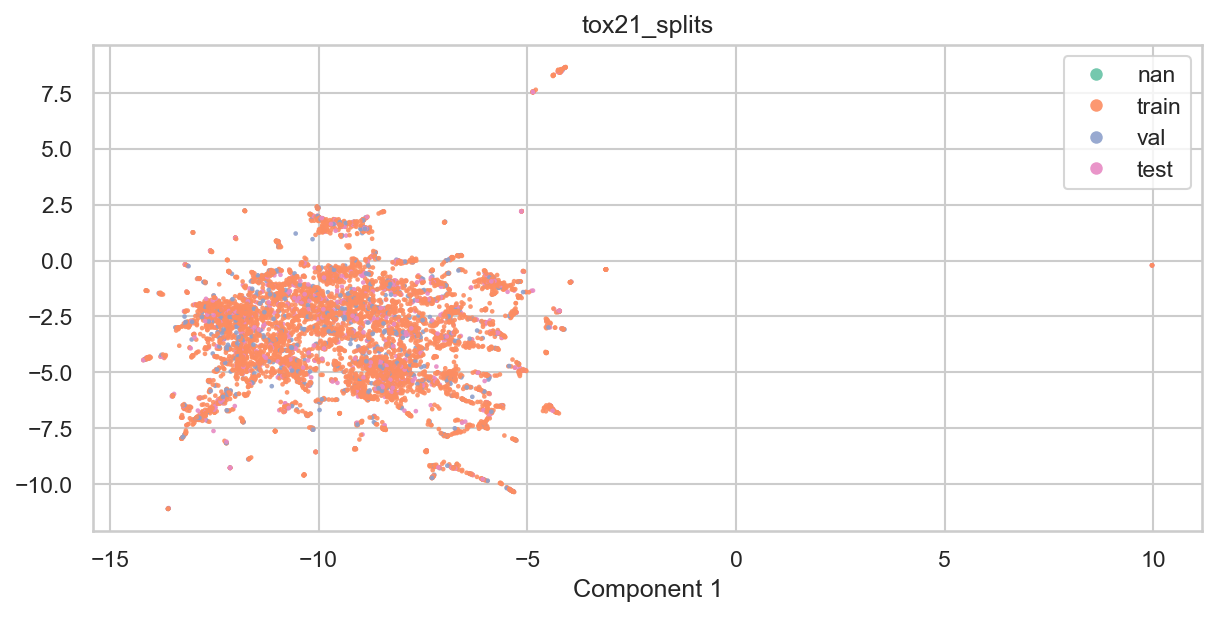

In [8]:
from utils.docs_utils import visualize_split_chemspace

fig = visualize_split_chemspace(
    mols=dataset.table[mol_col].to_list(),
    train_test_dict={"tox21_splits": splits},
)

# export the figure to remote path
from utils.auroris_utils import save_image

save_image(fig, dm.fs.join(FIGURE_DIR, f"chemspace.png"))

## Define multitask benchmarks with the above defined split

In [10]:
# Polaris only allows train and test splits. Here we merge the training set and validation set.
tox21_splits = (splits[0] + splits[1], splits[2])

In [13]:
benchmark_version = "v1"
benchmark_name = f"tox21-{benchmark_version}"
readme_name = "org-Graphium/tox21/tox21_benchmark_readme.md"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"


benchmark = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    target_types={col: "classification" for col in data_cols},
    input_cols=mol_col,
    split=tox21_splits,
    metrics=["f1"],
    tags=["toxicity", "multitask"],
    description="A multitask classification benchmark for Tox21 challenge.",
    owner=owner,
    readme=load_readme(readme_name),
)
path = benchmark.to_json(BENCHMARK_SAVE_DIR)
print(path)

2024-07-19 00:33:46.254 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-Graphium/tox21/benchmarks/tox21-v1/benchmark.json


In [14]:
# Upload to hub
benchmark.upload_to_hub(owner=owner, access="public")

2024-07-19 00:33:58.273 | SUCCESS  | polaris.hub.client:upload_benchmark:613 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/graphium/tox21-v1


{'id': '8SBX2whpERSKJvh4FfWhA',
 'createdAt': '2024-07-19T04:33:58.146Z',
 'deletedAt': None,
 'name': 'tox21-v1',
 'slug': 'tox21-v1',
 'description': 'A multitask classification benchmark for Tox21 challenge.',
 'tags': ['toxicity', 'multitask'],
 'userAttributes': {},
 'access': 'public',
 'isCertified': False,
 'polarisVersion': 'dev',
 'readme': '## Background\nTox21 is a well-known dataset for researchers in machine learning for drug discovery. The data set provided by the Tox21 Data Challenge included approximately 12 000 compounds. It consists of a multi-label classification task with 12 labels, with most labels missing and a strong imbalance towards the negative class. Each subchallenge required the prediction of a different type of toxicity. The sub-challenges were split between two panels: Seven of the twelve sub-challenges dealt with Nuclear Receptor (NR) signaling pathways, the remaining five with the Stress Response (SR) pathways. Nuclear receptors are important component